-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00259304 s
Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 10
     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     cylinder, center = (0,0,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0339341 s
-----------
Meep: using complex fields.
final residual = 6.34952e-09
Finished solve_cw after 149 CG iters (~ 2980 timesteps).
final residual = 8.70547e-10
Finished solve_cw after 141 CG iters (~ 2820 timesteps).
final residual = 5.03876e-11
Finished solve_cw after 164 CG iters (~ 3280 timesteps).
final residual = 8.48597e-12
Finished solve_cw after 149 CG iters (~ 2980 timesteps).
final residual = 8.83723e-13
Finished sol

/home/311514090/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/311514090/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


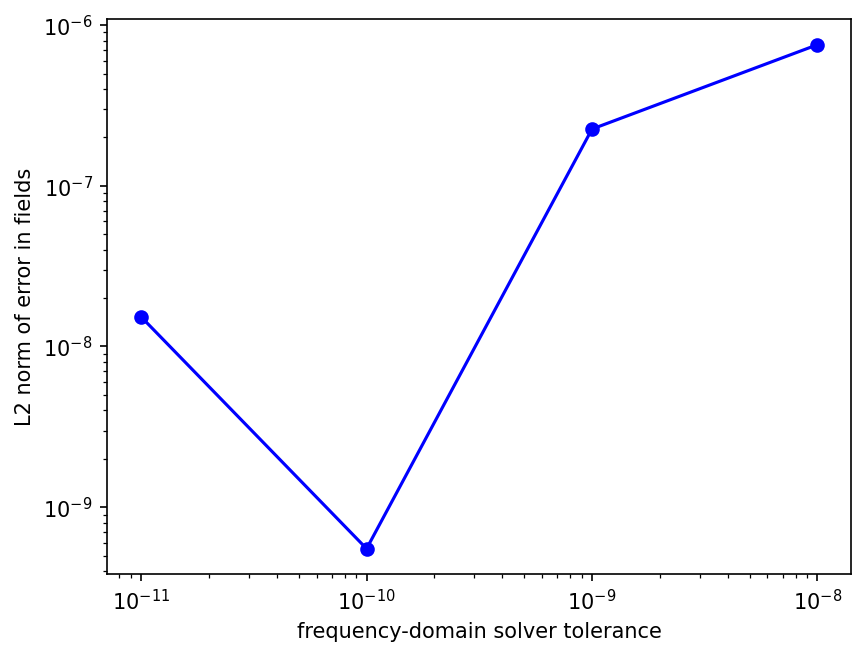

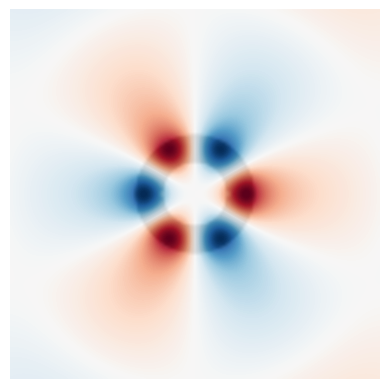

FAILED solve_cw test: error in the fields is NOT decreasing with increasing resolution


In [1]:
import meep as mp
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

n = 3.4
w = 1
r = 1
pad = 4
dpml = 2

sxy = 2*(r+w+pad+dpml)
cell_size = mp.Vector3(sxy,sxy)

pml_layers = [mp.PML(dpml)]

nonpml_vol = mp.Volume(mp.Vector3(), size=mp.Vector3(sxy-2*dpml,sxy-2*dpml))

geometry = [mp.Cylinder(radius=r+w, material=mp.Medium(index=n)),
            mp.Cylinder(radius=r)]

fcen = 0.118

src = [mp.Source(mp.ContinuousSource(fcen),
                 component=mp.Ez,
                 center=mp.Vector3(r+0.1)),
       mp.Source(mp.ContinuousSource(fcen),
                 component=mp.Ez,
                 center=mp.Vector3(-(r+0.1)),
                 amplitude=-1)]

symmetries = [mp.Mirror(mp.X,phase=-1),
              mp.Mirror(mp.Y,phase=+1)]

sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=src,
                    resolution=10,
                    force_complex_fields=True,
                    symmetries=symmetries,
                    boundary_layers=pml_layers)

num_tols = 5
tols = np.power(10, np.arange(-8.0,-8.0-num_tols,-1.0))
ez_dat = np.zeros((122,122,num_tols), dtype=np.complex_)

for i in range(num_tols):
    sim.init_sim()
    sim.solve_cw(tols[i], 10000, 10)
    ez_dat[:,:,i] = sim.get_array(vol=nonpml_vol, component=mp.Ez)

err_dat = np.zeros(num_tols-1)
for i in range(num_tols-1):
    err_dat[i] = LA.norm(ez_dat[:,:,i]-ez_dat[:,:,num_tols-1])

plt.figure(dpi=150)
plt.loglog(tols[:num_tols-1], err_dat, 'bo-');
plt.xlabel("frequency-domain solver tolerance");
plt.ylabel("L2 norm of error in fields");
plt.show()

eps_data = sim.get_array(vol=nonpml_vol, component=mp.Dielectric)
ez_data = np.real(ez_dat[:,:,num_tols-1])

plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

if np.all(np.diff(err_dat) < 0):
    print("PASSED solve_cw test: error in the fields is decreasing with increasing resolution")
else:
    print("FAILED solve_cw test: error in the fields is NOT decreasing with increasing resolution")